In [7]:
import zipfile, os

# ZIP dosyanızı proje klasörüne koyduğunuzdan emin olun
ZIP_PATH = "my_ecg_data.zip"
DATA_DIR = "data/my_ecg_data"

# 1. ZIP’i aç
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall("data")

# 2. Dosya/hasta dizinlerini listele
patients = sorted(d for d in os.listdir(DATA_DIR) if d.startswith("patient"))
print(f"Bulunan hastalar ({len(patients)}):", patients)

Bulunan hastalar (290): ['patient001', 'patient002', 'patient003', 'patient004', 'patient005', 'patient006', 'patient007', 'patient008', 'patient009', 'patient010', 'patient011', 'patient012', 'patient013', 'patient014', 'patient015', 'patient016', 'patient017', 'patient018', 'patient019', 'patient020', 'patient021', 'patient022', 'patient023', 'patient024', 'patient025', 'patient026', 'patient027', 'patient028', 'patient029', 'patient030', 'patient031', 'patient032', 'patient033', 'patient034', 'patient035', 'patient036', 'patient037', 'patient038', 'patient039', 'patient040', 'patient041', 'patient042', 'patient043', 'patient044', 'patient045', 'patient046', 'patient047', 'patient048', 'patient049', 'patient050', 'patient051', 'patient052', 'patient053', 'patient054', 'patient055', 'patient056', 'patient057', 'patient058', 'patient059', 'patient060', 'patient061', 'patient062', 'patient063', 'patient064', 'patient065', 'patient066', 'patient067', 'patient068', 'patient069', 'patient0

In [8]:
# ### 2. ECG SİNYALLERİNİ OKUMA ###
import wfdb

# Kaydı okumak için helper fonksiyon
def read_patient_records(patient_folder):
    path = os.path.join(DATA_DIR, patient_folder)
    # .hea dosyalarından record isimlerini çıkar
    recs = [f[:-4] for f in os.listdir(path) if f.endswith(".hea")]
    data = {}
    for rec in recs:
        rec_path = os.path.join(path, rec)
        wd = wfdb.rdrecord(rec_path)
        data[rec] = {
            "signal":   wd.p_signal,    # (n_samples, n_leads)
            "fs":       wd.fs,
            "channels": wd.sig_name
        }
    return data

# Tüm hastalar için oku
all_data = {pt: read_patient_records(pt) for pt in patients}
print("Patient001 örnek kayıtlar:", list(all_data["patient001"].keys()))

Patient001 örnek kayıtlar: ['s0010_re', 's0014lre', 's0016lre']


In [9]:
# ### 3. SİNYAL ÖN İŞLEME ###
import numpy as np
from scipy.signal import butter, filtfilt

# Band-pass filter (örn. 0.5–40 Hz)
def bandpass_filter(x, fs, low=0.5, high=40, order=4):
    nyq = fs/2
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return filtfilt(b, a, x)

# Normalizasyon (z-score)
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

# Örnek: tüm kayıtların ilk kanalını filtrele ve normalize et
preprocessed = {}
for pt, recs in all_data.items():
    preprocessed[pt] = {}
    for rec, d in recs.items():
        sig0 = d["signal"][:,0]         # lead-0
        f1   = bandpass_filter(sig0, d["fs"])
        nz   = normalize(f1)
        preprocessed[pt][rec] = {"sig": nz, "fs": d["fs"]}


In [10]:
# ### 4. ÖZNİTELİK ÇIKARMA ###
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch

def extract_features(sig, fs):
    # zaman-domain
    mean_v = np.mean(sig)
    std_v  = np.std(sig)
    skew_v = skew(sig)
    kurt_v = kurtosis(sig)
    # frekans-domain
    f, Pxx = welch(sig, fs, nperseg=fs*2)
    # toplam güç ve bantlar
    total_power = np.trapezoid(Pxx, f)
    lf = np.trapezoid(Pxx[(f>=0.04)&(f<0.15)], f[(f>=0.04)&(f<0.15)])
    hf = np.trapezoid(Pxx[(f>=0.15)&(f<0.4)], f[(f>=0.15)&(f<0.4)])
    return [mean_v, std_v, skew_v, kurt_v, lf/total_power, hf/total_power]

# tüm hasta-kayıtlara uygula
features, labels = [], []
for pt, recs in preprocessed.items():
    # pt == "CONTROLS" içindekilere 0, diğer patientXXX'lere 1
    lbl = 0 if pt.upper()=="CONTROLS" else 1
    for rec, d in recs.items():
        feats = extract_features(d["sig"], d["fs"])
        features.append(feats)
        labels.append(lbl)

df = pd.DataFrame(features, columns=[
    "mean", "std", "skew", "kurtosis", "LF_ratio", "HF_ratio"
])
df["label"] = labels

df.head()


,mean,std,skew,kurtosis,LF_ratio,HF_ratio,label
0,-1.517305e-17,1.0,-0.315541,4.105543,0.0,0.0,1
1,1.048544e-18,1.0,-0.035559,3.388439,0.0,0.0,1
2,-6.784696e-19,1.0,0.317196,3.726566,0.0,0.0,1
3,-8.264994e-18,1.0,-1.137969,4.113801,0.0,0.0,1
4,-9.868649e-19,1.0,2.543204,9.242270,0.0,0.0,1


In [11]:
# ### 5. MODEL OLUŞTURMA & EĞİTİM ###
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [12]:
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

y_pred = clf.predict(X_test)

print("Accuracy : ", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("Confusion Matrix:\n",
      confusion_matrix(y_test, y_pred, labels=[0,1]))

Accuracy :  1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0
Confusion Matrix:
 [[  0   0]
 [  0 165]]


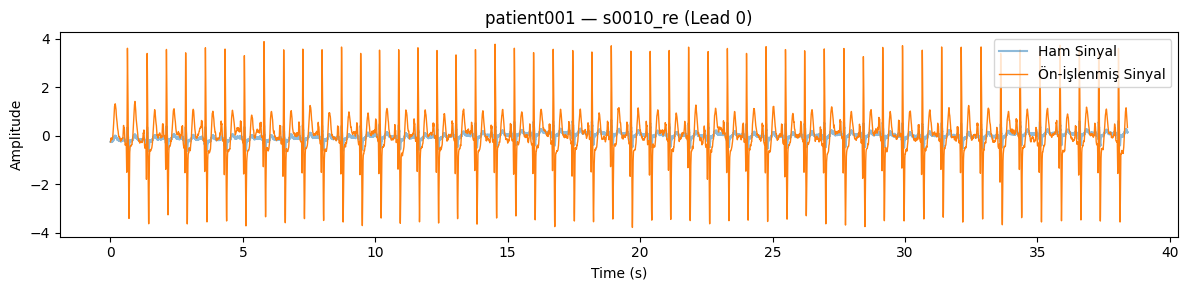

In [13]:
# ### Görselleştirme ###
import numpy as np
import matplotlib.pyplot as plt

# 1) Görselleştirmek istediğiniz hasta ve kaydı seçin
pt  = "patient001"
rec = "s0010_re"

# 2) Ham (raw) sinyali al
raw_sig = all_data[pt][rec]["signal"][:, 0]  # 1. kanal (lead-0)
fs      = all_data[pt][rec]["fs"]
t       = np.arange(len(raw_sig)) / fs

# 3) Ön‐işlenmiş sinyali al
proc_sig = preprocessed[pt][rec]["sig"]

# 4) Çizimi yap
plt.figure(figsize=(12, 3))
plt.plot(t, raw_sig,  label="Ham Sinyal", alpha=0.5)
plt.plot(t, proc_sig, label="Ön‐İşlenmiş Sinyal", linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"{pt} — {rec} (Lead 0)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
